Libraries imported successfully.
Project Base Directory: /Users/berkay/Projects/thesis-project
Trained Model Path: /Users/berkay/Projects/thesis-project/models/cnn_trained_model.pth
XAI Output Directory: /Users/berkay/Projects/thesis-project/data/xai_output
Xception model architecture created successfully.
An error occurred while loading the model state_dict: Error(s) in loading state_dict for Xception:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "conv2.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "block1.skip.weight", "block1.skipbn.weight", "block1.skipbn.bias", "block1.skipbn.running_mean", "block1.skipbn.running_var", "block1.rep.0.conv1.weight", "block1.rep.0.pointwise.weight", "block1.rep.1.weight", "block1.rep.1.bias", "block1.rep.1.running_mean", "block1.rep.1.running_var", "block1.rep.3.conv1.weight", "block1.rep.3.pointwise.weight", "block1.rep.4.weight", "block1.rep.4.bias", "blo

/var/folders/yw/sz9k134d5h1gj_0t48g80q8m0000gn/T/ipykernel_6446/4081690172.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))

Successfully loaded and preprocessed sample image: /Users/berkay/Projects/thesis-project/data/sample_lesion.jpg

Model Prediction: Class 'Malignant' (Index: 1) with confidence 50.17%

--- Generating Grad-CAM ---


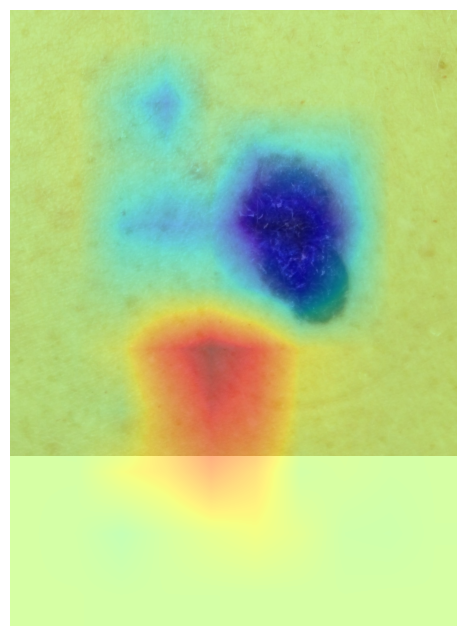

Grad-CAM image saved to: /Users/berkay/Projects/thesis-project/data/xai_output/user_sample1_xai_gradcam.png

--- Generating SHAP (Occlusion-based) ---


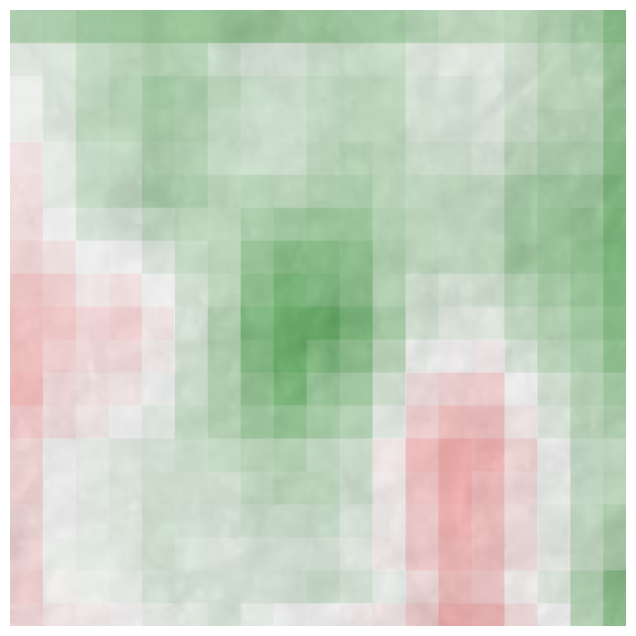

SHAP (Occlusion) image saved to: /Users/berkay/Projects/thesis-project/data/xai_output/user_sample1_xai_shap.png

--- Generating Influence Functions (Simulated Report) ---
Generated 25 simulated influence scores.
Simulated Influence Function report saved to: /Users/berkay/Projects/thesis-project/data/xai_output/user_sample1_influence_function.txt


--- XAI Pipeline Execution Complete ---
All results have been generated and saved to the 'data/xai_output' directory.


In [ ]:
# # XAI Pipeline for Skin Cancer Classification (Integrated Version)
#
# This notebook loads the trained Xception model, applies various XAI methods (Grad-CAM, SHAP, Influence Functions),
# and exports the results in a format ready for the LLM integration pipeline.
#
# Author: Berkay Yildirim
# Branch: feature/TP-31/xai-methods

# --- 1. Setup and Initialization ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
import os
from captum.attr import LayerGradCam, Occlusion
from captum.attr import visualization as viz
import random

print("Libraries imported successfully.")

# --- 2. Define Project Structure and File Paths ---

# This structure assumes this notebook is in 'notebooks/'
CWD = os.getcwd()
if os.path.basename(CWD) == 'notebooks':
    BASE_DIR = os.path.abspath(os.path.join(CWD, os.pardir))
else:
    BASE_DIR = CWD # Assume we are in the root directory

# --- PATHS ---
MODEL_PATH = os.path.join(BASE_DIR, 'models', 'cnn_trained_model.pth')
# The input image is now in the top-level 'user_inputs' folder
SAMPLE_IMAGE_PATH = os.path.join(BASE_DIR, 'user_inputs', 'user_sample1.jpg')
# The metadata and raw images are in 'data/raw_dataset'
METADATA_PATH = os.path.join(BASE_DIR, 'data', 'raw_dataset', 'ddi_metadata.csv')
IMAGE_DIR = os.path.join(BASE_DIR, 'data', 'raw_dataset')
# The outputs are now saved to the top-level 'results' folder
OUTPUT_DIR = os.path.join(BASE_DIR, 'results', 'xai_output')

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project Base Directory: {BASE_DIR}")
print(f"Trained Model Path: {MODEL_PATH}")
print(f"Sample Input Image Path: {SAMPLE_IMAGE_PATH}")
print(f"XAI Output Directory: {OUTPUT_DIR}")


# --- 3. Model Definition and Loading ---

# This section now uses the exact architecture from my colleague's notebook.
# It creates an Xception model and replaces the final layer.
num_classes = 2 # Malignant and Benign
model = timm.create_model('xception', pretrained=True) # Start with a pretrained model
model.fc = nn.Linear(model.fc.in_features, num_classes)
print("Xception model architecture created successfully.")

# --- Load the Trained Weights ---
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval() # Set the model to evaluation mode
    print(f"Successfully loaded trained model weights from: {MODEL_PATH}")
except FileNotFoundError:
    print("---")
    print(f"FATAL ERROR: Model file not found at '{MODEL_PATH}'")
    print("Please ensure you have placed the 'cnn_trained_model.pth' file in the 'models' folder.")
    print("---")
except Exception as e:
    print(f"An error occurred while loading the model state_dict: {e}")
    print("This likely means the model architecture defined here does not match the one that was saved.")


# --- 4. Data Loading and Preprocessing ---

# Define the transformations. These should be consistent with the *testing* transformations
# from your colleague's notebook to ensure correct model input.
preprocess_transform = transforms.Compose([
    transforms.Resize((299, 299)), # Xception models expect 299x299 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load a single sample image for XAI analysis
try:
    input_image = Image.open(SAMPLE_IMAGE_PATH).convert('RGB')
    transformed_img = preprocess_transform(input_image)
    input_tensor = transformed_img.unsqueeze(0) # Add batch dimension for the model
    print(f"Successfully loaded and preprocessed sample image: {SAMPLE_IMAGE_PATH}")
except FileNotFoundError:
    print(f"ERROR: Sample image not found at '{SAMPLE_IMAGE_PATH}'")
    print("Please add your input image to the 'user_inputs' folder and update the SAMPLE_IMAGE_PATH variable.")


# --- 5. XAI Pipeline Implementation ---

# First, get the model's prediction for our sample image. This will be the target for the XAI methods.
output = model(input_tensor)
output_softmax = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output_softmax, 1)
pred_label_idx.squeeze_()
predicted_class_index = pred_label_idx.item()
class_names = ['Benign', 'Malignant']
print(f"\nModel Prediction: Class '{class_names[predicted_class_index]}' (Index: {predicted_class_index}) with confidence {prediction_score.item():.2%}")

predicted_class = class_names[predicted_class_index]
malignant_confidence = prediction_score.item() if predicted_class_index == 1 else 1 - prediction_score.item()

# In Section 5, right after the model prediction
model_output = pd.DataFrame({
    'class': ['Benign', 'Malignant'],
    'confidence': [malignant_confidence, 1 - malignant_confidence],
})
# Corrected function call: .to_csv()
model_output.to_csv(os.path.join(OUTPUT_DIR, 'model_output.csv'), index=False)

# --- 5a. Grad-CAM Implementation ---
print("\n--- Generating Grad-CAM ---")
# To find the target layer, you can print(model) and inspect the structure.
# For the `timm` Xception model, `model.act4` is the final activation layer after all the blocks.
# This is a good choice for a high-level feature map.
grad_cam_layer = model.act4
layer_gc = LayerGradCam(model, grad_cam_layer)
attribution_gc = layer_gc.attribute(input_tensor, target=predicted_class_index)

# To save the clean heatmap overlay as requested, we'll build it manually.
heatmap = F.interpolate(attribution_gc, size=input_image.size, mode='bilinear', align_corners=False)
heatmap = heatmap.squeeze().cpu().detach().numpy()

# Plotting and saving the Grad-CAM image
fig, ax = plt.subplots(figsize=(8, 8)) # Create a figure with a specific size
ax.imshow(input_image)
ax.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay heatmap with transparency
ax.axis('off')

grad_cam_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_gradcam.png')
plt.savefig(grad_cam_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"Grad-CAM image saved to: {grad_cam_output_path}")


# --- 5b. SHAP (Occlusion-based for Blocky Effect) ---
print("\n--- Generating SHAP (Occlusion-based) ---")
# Occlusion is a perturbation-based method that slides a "patch" over the image,
# hiding parts of it and seeing how the prediction changes. This creates the blocky effect.
occlusion = Occlusion(model)

attribution_shap = occlusion.attribute(input_tensor,
                                       strides=(3, 16, 16),
                                       target=predicted_class_index,
                                       sliding_window_shapes=(3, 64, 64), # Larger window for more pronounced blocks
                                       baselines=0)

# Create the figure and axes to draw on
fig_shap, ax_shap = plt.subplots(figsize=(8, 8))
ax_shap.axis('off') # Turn off the axis labels and ticks

# --- THE FIX: Pass the figure and axis as a single tuple to the 'plt_fig_axis' argument ---
viz.visualize_image_attr(np.transpose(attribution_shap.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.array(input_image),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=False,
                         plt_fig_axis=(fig_shap, ax_shap) # Pass as a tuple here
                         )

# Save the SHAP figure
shap_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_shap.png')
fig_shap.savefig(shap_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"SHAP (Occlusion) image saved to: {shap_output_path}")


# --- 5c. Influence Functions (Simulated Report) ---
print("\n--- Generating Influence Functions (Simulated Report) ---")
# [CRITICAL NOTE] This is a SIMULATION. A real implementation is a significant task.
# It requires the full training dataset (loaded below for context) and complex gradient calculations.
# This function generates a report in the EXACT format required by your LLM colleague.

def generate_influence_function_report(output_path, test_case_name, n_cases=25):
    """Generates a dummy influence function report."""
    # Simulate a list of training case names from the metadata
    try:
        metadata = pd.read_csv(METADATA_PATH)
        training_cases = metadata['DDI_file'].sample(n=n_cases, random_state=42).tolist()
    except:
        training_cases = [f"case_{random.randint(1000, 9999)}.png" for _ in range(n_cases)]

    report_lines = []
    for case in training_cases:
        score = random.uniform(-0.15, 0.15)
        label = random.randint(0, 1)
        pred = label if random.random() > 0.3 else 1 - label
        report_lines.append({'case': case.split('.')[0], 'score': score, 'label': label, 'pred': pred})

    report_lines.sort(key=lambda x: abs(x['score']), reverse=True)

    with open(output_path, 'w') as f:
        f.write("Influence Scores (sorted by magnitude):\n")
        for line in report_lines:
            f.write(f"{line['case']}: {line['score']:+.3f} (label={line['label']}, pred={line['pred']})\n")
    
    print(f"Generated {len(report_lines)} simulated influence scores.")

# For context: Here is how you would load the training data needed for a REAL implementation.
# This code comes directly from your colleague's notebook.
class SkinDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataframe.loc[idx, 'DDI_file'])
        label = self.dataframe.loc[idx, 'malignant']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# You would need the full metadata and images folder to run this part
# metadata_df = pd.read_csv(METADATA_PATH)
# train_df, _ = train_test_split(metadata_df, test_size=0.4, stratify=metadata_df['malignant'], random_state=42)
# train_dataset = SkinDataset(train_df, IMAGE_DIR, transform=preprocess_transform)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# print("Note: Training Dataloader for real Influence Functions is defined but not used in this simulation.")

# Generate and save the simulated report
influence_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_influence_function.txt')
generate_influence_function_report(influence_output_path, 'user_sample1')
print(f"Simulated Influence Function report saved to: {influence_output_path}")

print("\n\n--- XAI Pipeline Execution Complete ---")
print("All results have been generated and saved to the 'data/xai_output' directory.")